# GPM: A graph convolutional network based reinforcement learning framework for portfolio management

In this document, we will make use of a graph neural network architecture called GPM, introduced in the following paper:

- Si Shi, Jianjun Li, Guohui Li, Peng Pan, Qi Chen & Qing Sun. (2022). GPM: A graph convolutional network based reinforcement learning framework for portfolio management. https://doi.org/10.1016/j.neucom.2022.04.105.

### Note
If you're using the portfolio optimization environment, consider citing the following paper (in adittion to FinRL references):

- Caio Costa, & Anna Costa (2023). POE: A General Portfolio Optimization Environment for FinRL. In *Anais do II Brazilian Workshop on Artificial Intelligence in Finance* (pp. 132–143). SBC. https://doi.org/10.5753/bwaif.2023.231144.

```
@inproceedings{bwaif,
 author = {Caio Costa and Anna Costa},
 title = {POE: A General Portfolio Optimization Environment for FinRL},
 booktitle = {Anais do II Brazilian Workshop on Artificial Intelligence in Finance},
 location = {João Pessoa/PB},
 year = {2023},
 keywords = {},
 issn = {0000-0000},
 pages = {132--143},
 publisher = {SBC},
 address = {Porto Alegre, RS, Brasil},
 doi = {10.5753/bwaif.2023.231144},
 url = {https://sol.sbc.org.br/index.php/bwaif/article/view/24959}
}

```

## Installation and imports

To run this notebook in google colab, uncomment the cells below.

In [1]:
## install finrl library
# !sudo apt install swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

The following library is necessary to get market trading days and create a datetime column in the training data.

In [2]:
!pip install pandas-market-calendars

In [3]:
## Hide matplotlib warnings
# import warnings
# warnings.filterwarnings('ignore')

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

#### Import the necessary code libraries

In [4]:
import torch

import numpy as np
import pandas as pd
import pandas_market_calendars as mcal

from torch_geometric.utils import k_hop_subgraph

from finrl.meta.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.rlportfolio.models import DRLAgent

device = 'mps' if torch.cuda.is_available() else 'cpu'

## Fetch data

We are going to use the same data used in the paper. The original data can be found in [Temporal_Relational_Stock_Ranking repository](https://github.com/fulifeng/Temporal_Relational_Stock_Ranking), but it's not in a FinRL friendly format. So, we're going to get the processed and FinRL-friendly data from [Temporal_Relational_Stock_Ranking_FinRL repository](https://github.com/C4i0kun/Temporal_Relational_Stock_Ranking_FinRL).

In [5]:
# download repository with data and extract tar.gz file with processed temporal data
# !curl -L -o Temporal_Relational_Stock_Ranking_FinRL-main.zip https://github.com/CaioSBC/Temporal_Relational_Stock_Ranking_FinRL/archive/refs/heads/main.zip
# !unzip Temporal_Relational_Stock_Ranking_FinRL-main.zip
# !mv Temporal_Relational_Stock_Ranking_FinRL-main Temporal_Relational_Stock_Ranking_FinRL
# !tar -xzvf Temporal_Relational_Stock_Ranking_FinRL/temporal_data/temporal_data_processed.tar.gz -C Temporal_Relational_Stock_Ranking_FinRL/temporal_data

In [6]:
nasdaq_temporal = pd.read_csv("Temporal_Relational_Stock_Ranking_FinRL/temporal_data/NASDAQ_temporal_data.csv")
nasdaq_temporal

,day,open,high,low,close,volume,tic
0,0,0.270533,0.269522,0.267237,0.263333,0.275333,AABA
1,0,0.238730,0.237522,0.239888,0.240502,0.248031,AAON
2,0,0.424556,0.424768,0.429769,0.442628,0.445018,AAPL
3,0,0.650667,0.648412,0.634492,0.631473,0.667839,AAWW
4,0,0.766565,0.761693,0.759330,0.750061,0.788157,AAXJ
...,...,...,...,...,...,...,...
1277365,1244,0.909992,0.918809,0.912345,0.922698,0.913021,ZBRA
1277366,1244,0.660990,0.648907,0.636086,0.630816,0.665167,ZEUS
1277367,1244,0.981600,0.961674,0.926768,0.914257,0.984345,ZION
1277368,1244,0.980227,0.974903,0.960225,0.964956,0.997580,ZIV


It can be seen above that the temporal data does not have a date column, with datetime data. Since the simulation environment needs a date column, we will add it using the pandas market calendars unit. As stated in the original paper, the temporal data ranges from 2013-01-02 to 2017-12-08.

In [7]:
nasdaq = mcal.get_calendar("NASDAQ")
datetimes = nasdaq.valid_days("2013-01-02", "2017-12-08")
nasdaq_temporal["date"] = nasdaq_temporal["day"].apply(lambda day: datetimes[day]).dt.strftime("%Y-%m-%d")
nasdaq_temporal

,day,open,high,low,close,volume,tic,date
0,0,0.270533,0.269522,0.267237,0.263333,0.275333,AABA,2013-01-02
1,0,0.238730,0.237522,0.239888,0.240502,0.248031,AAON,2013-01-02
2,0,0.424556,0.424768,0.429769,0.442628,0.445018,AAPL,2013-01-02
3,0,0.650667,0.648412,0.634492,0.631473,0.667839,AAWW,2013-01-02
4,0,0.766565,0.761693,0.759330,0.750061,0.788157,AAXJ,2013-01-02
...,...,...,...,...,...,...,...,...
1277365,1244,0.909992,0.918809,0.912345,0.922698,0.913021,ZBRA,2017-12-08
1277366,1244,0.660990,0.648907,0.636086,0.630816,0.665167,ZEUS,2017-12-08
1277367,1244,0.981600,0.961674,0.926768,0.914257,0.984345,ZION,2017-12-08
1277368,1244,0.980227,0.974903,0.960225,0.964956,0.997580,ZIV,2017-12-08


In [8]:
nasdaq_edge_index = np.load("Temporal_Relational_Stock_Ranking_FinRL/relational_data/edge_indexes/NASDAQ_sector_industry_edge_index.npy")
nasdaq_edge_index

array([[   0,   15,    0, ..., 1021, 1014, 1024],
       [  15,    0,   18, ..., 1011, 1024, 1014]])

In [9]:
nasdaq_edge_type = np.load("Temporal_Relational_Stock_Ranking_FinRL/relational_data/edge_types/NASDAQ_sector_industry_edge_type.npy")
nasdaq_edge_type

array([ 0,  0,  0, ...,  1, 26, 26])

### Simplify Data

The graph loaded is too big, causing the training process to be extremely slow. So we are going to remove some of the stocks in the graph structure so that only stocks from 2 hops of the ones in our portfolio are considered.

In [10]:
list_of_stocks = nasdaq_temporal["tic"].unique().tolist()
tics_in_portfolio = ["AAPL", "CMCSA", "CSCO", "FB", "HBAN", "INTC", "MSFT", "MU", "NVDA", "QQQ", "XIV"]

portfolio_nodes = []
for tic in tics_in_portfolio:
    portfolio_nodes.append(list_of_stocks.index(tic))
portfolio_nodes

[2, 185, 215, 310, 395, 464, 596, 603, 637, 768, 1014]

In [11]:
nodes_kept, new_edge_index, nodes_to_select, edge_mask = k_hop_subgraph(
    torch.LongTensor(portfolio_nodes),
    1,
    torch.from_numpy(nasdaq_edge_index),
    relabel_nodes=True,
)

In [12]:
# reduce temporal data
nodes_kept = nodes_kept.tolist()
nasdaq_temporal["tic_id"], _ = pd.factorize(nasdaq_temporal["tic"], sort=True)
nasdaq_temporal = nasdaq_temporal[nasdaq_temporal["tic_id"].isin(nodes_kept)]
nasdaq_temporal = nasdaq_temporal.drop(columns="tic_id")
nasdaq_temporal

,day,open,high,low,close,volume,tic,date
2,0,0.424556,0.424768,0.429769,0.442628,0.445018,AAPL,2013-01-02
4,0,0.766565,0.761693,0.759330,0.750061,0.788157,AAXJ,2013-01-02
7,0,0.244700,0.244212,0.238217,0.231041,0.251322,ABCB,2013-01-02
8,0,0.689403,0.698864,0.695715,0.675068,0.708124,ABCO,2013-01-02
13,0,0.566419,0.564621,0.563147,0.560503,0.579132,ACIW,2013-01-02
...,...,...,...,...,...,...,...,...
1277358,1244,0.923544,0.922537,0.896003,0.888519,0.966042,XIV,2017-12-08
1277359,1244,0.919490,0.931946,0.950966,0.960872,0.920000,XLNX,2017-12-08
1277361,1244,0.736906,0.747264,0.744030,0.745198,0.743781,YNDX,2017-12-08
1277367,1244,0.981600,0.961674,0.926768,0.914257,0.984345,ZION,2017-12-08


In [13]:
# reduce edge type
new_edge_type = torch.from_numpy(nasdaq_edge_type)[edge_mask]
_, new_edge_type = torch.unique(new_edge_type, return_inverse=True)
new_edge_type

tensor([0, 0, 0,  ..., 2, 6, 6])

### Instantiate Environment

Using the `PortfolioOptimizationEnv`, it's easy to instantiate a portfolio optimization environment for reinforcement learning agents. In the example below, we use the dataframe created before to start an environment.

In [14]:
df_portfolio = nasdaq_temporal[["date", "day", "tic", "close", "high", "low"]]

df_portfolio_train = df_portfolio[df_portfolio["day"] < 979]

# In the test period, the dataframe must have 50 more items so that the agent
# can take action in the first day of the testing set. 
df_portfolio_test = df_portfolio[df_portfolio["day"] >= 929]

environment_train = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=100000,
        comission_fee_pct=0.0025,
        state_normalization="by_last_close",
        time_window=50,
        features=["close", "high", "low"],
        time_column="date",
        time_format="%Y-%m-%d",
        tics_in_portfolio=tics_in_portfolio,
        print_metrics=False,
        plot_graphs=False,
    )

environment_test = PortfolioOptimizationEnv(
        df_portfolio_test,
        initial_amount=100000,
        comission_fee_pct=0.0025,
        state_normalization="by_last_close",
        time_window=50,
        features=["close", "high", "low"],
        time_column="date",
        time_format="%Y-%m-%d",
        tics_in_portfolio=tics_in_portfolio,
        print_metrics=False,
        plot_graphs=False,
    )

### Instantiate Model

Now, we can instantiate the model using FinRL API. In this example, we are going to use the EI3 architecture introduced by Jiang et. al.

:exclamation: **Note:** Remember to set the architecture's `time_window` parameter with the same value of the environment's `time_window`.

In [19]:
# set PolicyGradient parameters
model_kwargs = {
    "lr": 5e-5,
    "sample_bias": 0.001,
}

# here, we can set GPM's parameters
policy_kwargs = {
    "edge_index": new_edge_index,
    "edge_type": new_edge_type,
    "nodes_to_select": nodes_to_select
}

model = DRLAgent(environment_train).get_model("pg", "gpm", model_kwargs, policy_kwargs, device)

### Train Model

In [20]:
DRLAgent.train_model(
    model, 2000, val_env=environment_test, val_gradient_steps=30
)

Completed: 100%|██████████| 2000/2000 [1:48:55<00:00,  3.27s/step, fapv=4.47, mdd=-0.143, sharpe=0.427, val_fapv=1.42, val_mdd=-0.0618, val_sharpe=0.733]       


In [32]:
import pandas_market_calendars as mcal

nasdaq = mcal.get_calendar("NASDAQ")
datetimes = nasdaq.valid_days("2013-01-02", "2017-12-08")
nasdaq_temporal["date"] = nasdaq_temporal["day"].apply(lambda day: datetimes[day]).dt.strftime("%Y-%m-%d")
nasdaq_temporal
# pd.to_datetime(nasdaq_temporal["day"], unit=)

,day,open,high,low,close,volume,tic,date
2,0,0.424556,0.424768,0.429769,0.442628,0.445018,AAPL,2013-01-02
4,0,0.766565,0.761693,0.759330,0.750061,0.788157,AAXJ,2013-01-02
7,0,0.244700,0.244212,0.238217,0.231041,0.251322,ABCB,2013-01-02
8,0,0.689403,0.698864,0.695715,0.675068,0.708124,ABCO,2013-01-02
13,0,0.566419,0.564621,0.563147,0.560503,0.579132,ACIW,2013-01-02
...,...,...,...,...,...,...,...,...
1277358,1244,0.923544,0.922537,0.896003,0.888519,0.966042,XIV,2017-12-08
1277359,1244,0.919490,0.931946,0.950966,0.960872,0.920000,XLNX,2017-12-08
1277361,1244,0.736906,0.747264,0.744030,0.745198,0.743781,YNDX,2017-12-08
1277367,1244,0.981600,0.961674,0.926768,0.914257,0.984345,ZION,2017-12-08


### Save Model

In [21]:
torch.save(model.train_policy.state_dict(), "policy_GPM.pt")

## Test Model

Following the idea from the original article, we will evaluate the performance of the trained model in the test period. We will also compare with the Uniform buy and hold strategy.

### Test GPM architecture

It's important no note that, in this code, we load the saved policy even though it's not necessary just to show how to save and load your model.

In [22]:
GPM_results = {
    "train": environment_train._asset_memory["final"],
    "test": environment_test._asset_memory["final"],
}

### Test Uniform Buy and Hold
For comparison, we will also test the performance of a uniform buy and hold strategy. In this strategy, the portfolio has no remaining cash and the same percentage of money is allocated in each asset.

In [26]:
UBAH_results = {}

PORTFOLIO_SIZE = len(tics_in_portfolio)

# train period
terminated = False
environment_train.reset()
action = None
while not terminated:
    if action is None:
        action = [0] + [1 / PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    else:
        action = environment_train._final_weights[-1]
    _, _, terminated, _, _ = environment_train.step(action)
UBAH_results["train"] = environment_train._asset_memory["final"]

# test period
terminated = False
environment_test.reset()
action = None
while not terminated:
    if action is None:
        action = [0] + [1 / PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    else:
        action = environment_test._final_weights[-1]
    _, _, terminated, _, _ = environment_test.step(action)
UBAH_results["test"] = environment_test._asset_memory["final"]

### Plot graphics

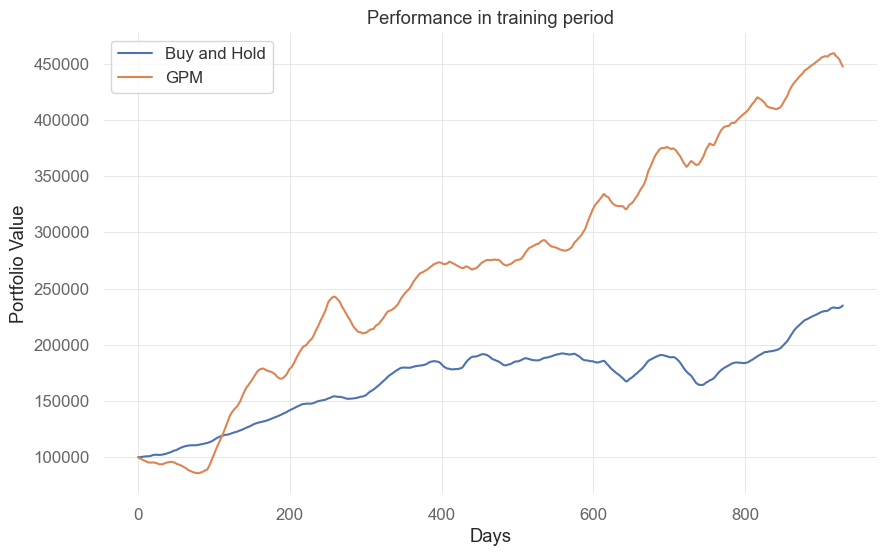

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"], label="Buy and Hold")
plt.plot(GPM_results["train"], label="GPM")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

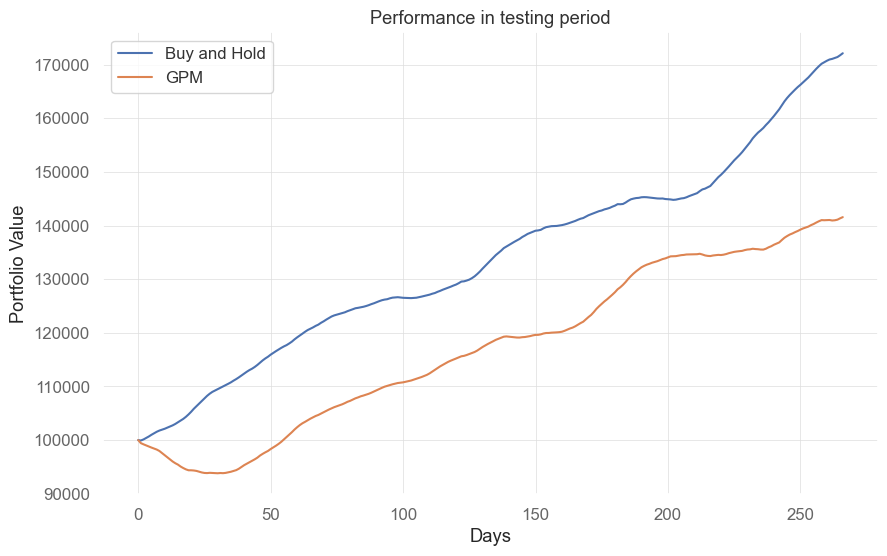

In [28]:
plt.plot(UBAH_results["test"], label="Buy and Hold")
plt.plot(GPM_results["test"], label="GPM")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in testing period")
plt.legend()

plt.show()

With only two training episodes, we can see that GPM achieves better performance than buy and hold strategy, but according to the original article, that performance could be better. Hyperparameter tuning must be performed. Additionaly, we used softmax temperature equal to one, something that can be changed to achieve better performance as stated in the original article.